In [1]:
from methods import *
from model import LogisticInstance
import numpy as np
from cvxopt import matrix, solvers
import time
import matplotlib.pyplot as plt

solvers.options['show_progress'] = False

In [2]:
def test(method_name, method, real_f_name, real_f, draw=True, **kwargs):
    t = time.monotonic()
    x_opt = method(**kwargs)
    print('{}:\n  x_opt = {}\n  {} = {}\n  time = {}s\n'.format(method_name, x_opt,
                                                                real_f_name, real_f(x_opt),
                                                                time.monotonic() - t))
    if draw:
        plt.plot(np.arange(len(method.x)), method.x, color='g', label=r'$x_k$')
        plt.plot(np.arange(len(method.x)), x_opt * np.ones(len(method.x)), color='r', label=r'$x_{opt}$')
        plt.show()

### Simple 1D case

\begin{align*}
\frac{e^{x-2}(5-x)}{1 + e^{x-2}} &\to max \\
x & \le 2
\end{align*}

Theoretical answer is $x_{opt} \sim 2.44$ in unconditional case and $x_{opt} = 2$ otherwise.

In [3]:
a = np.array([1.])
b = -2.
c = np.array([-1.])
d = 5.
F = np.array([[1.]])
g = np.array([2.])

issue = LogisticInstance(a, b, c, d, F, g)

Gradient descent, conv. by argument, h_k = 0.1:
  x_opt = [2.44261703]
  expected_profit = 1.5571455818420734
  time = 0.01596466299997701s



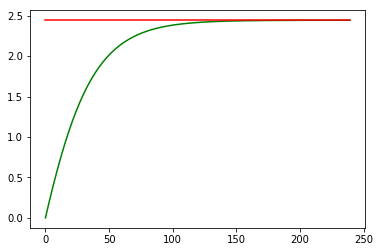

Gradient descent, conv. by argument, h_k = 1/k:
  x_opt = [2.34713717]
  expected_profit = 1.554373820931351
  time = 0.1999695430004067s



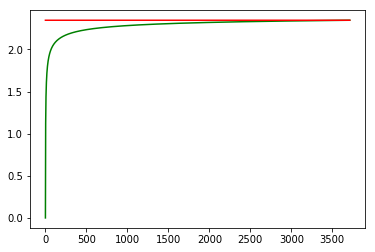

Gradient descent, conv. by argument, h_k = 1/k, xo > x_opt:
  x_opt = [2.46707963]
  expected_profit = 1.5569666769785153
  time = 0.05329459099993983s



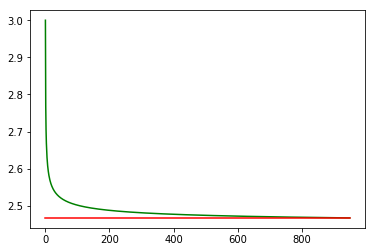

Gradient descent, conv. by argument, h_k = 1/k:
  x_opt = [2.24594916]
  expected_profit = 1.545516050628967
  time = 0.033961667999392375s



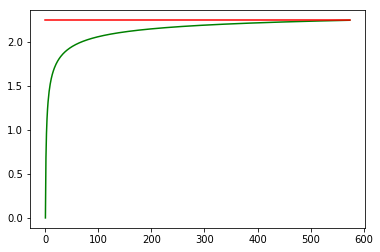

Gradient descent, conv. by argument, h_k = 1/sqrt(k):
  x_opt = [2.44255797]
  expected_profit = 1.5571455722441265
  time = 0.01078574700113677s



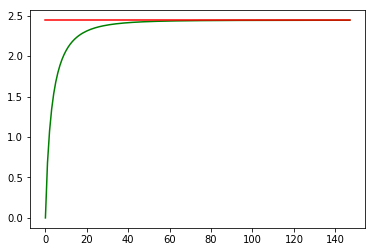



Accelerated Nesterov gradient descent, h_k = 0.5:
  x_opt = [2.4427758]
  expected_profit = 1.5571455971164652
  time = 0.004655421000279603s



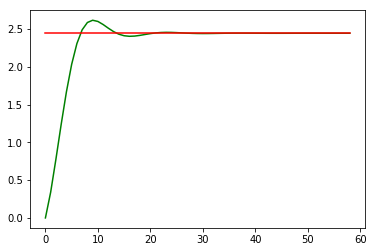

Accelerated Nesterov gradient descent, h_k = 1/sqrt(k):
  x_opt = [2.44126018]
  expected_profit = 1.5571448252478892
  time = 0.003146279999782564s



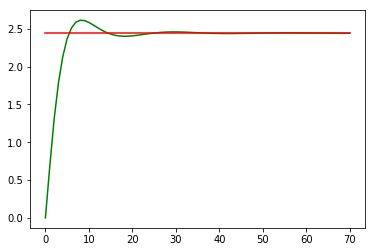



Newton method:
  x_opt = [2.4428544]
  expected_profit = 1.5571455989976113
  time = 0.0012964170000486774s



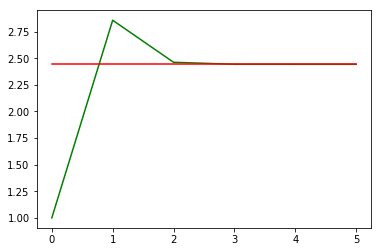

Broyden-Fletcher-Goldfarb-Shanno method (quasy-Newton):
  x_opt = [2.44280694]
  expected_profit = 1.557145598311869
  time = 0.0050999819995922735s



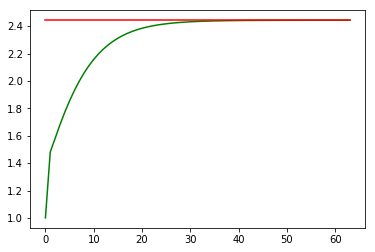

In [4]:
# unconditional optimization

f = lambda x: -issue.log_expected_profit(x)
df = lambda x: -issue.dlog_expected_profit(x)
d2f = lambda x: -issue.d2log_expected_profit(x)



test('Gradient descent, conv. by argument, h_k = 0.1', 
     GradientDescent(h=0.1), 
     'expected_profit', issue.expected_profit,
     f=f, x0=np.zeros(issue.a.shape[0]), df=df)

test('Gradient descent, conv. by argument, h_k = 1/k', 
     GradientDescent(h=lambda step: 1. / step), 
     'expected_profit', issue.expected_profit,
     f=f, x0=np.zeros(issue.a.shape[0]), df=df)

test('Gradient descent, conv. by argument, h_k = 1/k, xo > x_opt', 
     GradientDescent(h=lambda step: 1. / step), 
     'expected_profit', issue.expected_profit,
     f=f, x0=3*np.ones(issue.a.shape[0]), df=df)

test('Gradient descent, conv. by argument, h_k = 1/k', 
     GradientDescent(h=lambda step: 1. / step,
                     convergence_condition=Convergence.ByValue), 
     'expected_profit', issue.expected_profit,
     f=f, x0=np.zeros(issue.a.shape[0]), df=df)

test('Gradient descent, conv. by argument, h_k = 1/sqrt(k)', 
     GradientDescent(h=lambda step: step ** -0.5), 
     'expected_profit', issue.expected_profit,
     f=f, x0=np.zeros(issue.a.shape[0]), df=df)

print('\n')

test('Accelerated Nesterov gradient descent, h_k = 0.5', 
     AcceleratedNesterovGradientDescent(),
     'expected_profit', issue.expected_profit,
     f=f, x0=np.zeros(issue.a.shape[0]), df=df)

test('Accelerated Nesterov gradient descent, h_k = 1/sqrt(k)', 
     AcceleratedNesterovGradientDescent(h=lambda step: step ** -0.5),
     'expected_profit', issue.expected_profit,
     f=f, x0=np.zeros(issue.a.shape[0]), df=df)

print('\n')

test('Newton method',
     NewtonMethod(),
     'expected_profit', issue.expected_profit,
     f=f, x0=np.array([1.]), df=df, d2f=d2f)

test('Broyden-Fletcher-Goldfarb-Shanno method (quasy-Newton)', 
     BroydenFletcherGoldfarbShannoMethod(),
     'expected_profit', issue.expected_profit,
     f=f, x0=np.array([1.]), df=df)

Penalty method, pen_k = [1] * (k-1), ext_pen_func = max(0, x)^0.7,
unconditional method -- gradient descent with h_k=0.01:
  x_opt = [2.00233491]
  expected_profit = 1.500582363040146
  time = 0.1356189229991287s



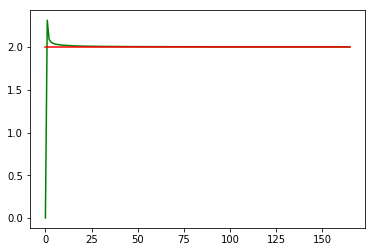

Conditional gradient method, k = 2 / (3 + step):
  x_opt = [1.99783784]
  expected_profit = 1.4994582913553598
  time = 0.016504576999068377s



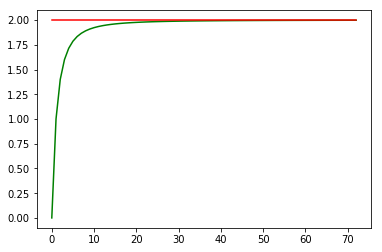

Conditional gradient method, k = 1 / sqrt(step):
  x_opt = [2.]
  expected_profit = 1.5
  time = 0.0009593750000931323s



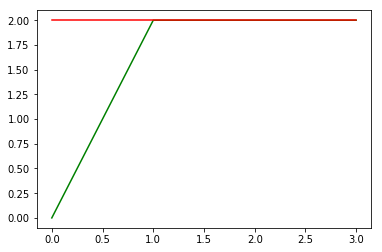

In [5]:
# conditional

g = lambda x: np.dot(issue.F , x) -issue.g
dg = lambda x: issue.F

test('''Penalty method, pen_k = [1] * (k-1), ext_pen_func = max(0, x)^0.7,
unconditional method -- gradient descent with h_k=0.01''', 
     PenaltyMethod(),
     'expected_profit', issue.expected_profit,
     f=f, x0=np.zeros(issue.a.shape[0]), df=df,
     g=g, dg=dg)

test('Conditional gradient method, k = 2 / (3 + step)',
     ConditionalGradientMethod(),
     'expected_profit', issue.expected_profit,
     f=f, x0=np.zeros(issue.a.shape[0]), df=df,
     g=g)

test('Conditional gradient method, k = 1 / sqrt(step)',
     ConditionalGradientMethod(k=lambda step: 1. / np.sqrt(step)),
     'expected_profit', issue.expected_profit,
     f=f, x0=np.zeros(issue.a.shape[0]), df=df,
     g=g)

In [6]:
# linear

A = matrix(-issue.a)
B = matrix([issue.b])
F = matrix(issue.F)
G = matrix(issue.g)


sol = solvers.lp(A, F, G)
print('  x_opt = ', np.array(sol['x']).T[0], '\n   prob = ', issue.prob(np.array(sol['x']).T[0]))

  x_opt =  [2.] 
   prob =  0.5


In [7]:
a = np.array([1., 1.])
b = -2.
c = np.array([-1., -1.])
d = 5.
F = np.array([])
g = np.array([])

issue = LogisticInstance(a, b, c, d, None, None)


f = lambda x: -issue.log_expected_profit(x)
df = lambda x: -issue.dlog_expected_profit(x)
d2f = lambda x: -issue.d2log_expected_profit(x)

In [8]:
# unconditional, nD

test('Gradient descent, conv. by argument, h_k = 0.1', 
     GradientDescent(h=0.1), 
     'expected_profit', issue.expected_profit, draw=False,
     f=f, x0=np.zeros(issue.a.shape[0]), df=df)


test('Accelerated Nesterov gradient descent, h_k = 1/sqrt(k)', 
     AcceleratedNesterovGradientDescent(h=lambda step: step ** -0.5),
     'expected_profit', issue.expected_profit, draw=False,
     f=f, x0=np.zeros(issue.a.shape[0]), df=df)

test('Broyden-Fletcher-Goldfarb-Shanno method (quasi Newton)', 
     BroydenFletcherGoldfarbShannoMethod(),
     'expected_profit', issue.expected_profit, draw=False,
     f=f, x0=np.zeros(issue.a.shape[0]), df=df)


Gradient descent, conv. by argument, h_k = 0.1:
  x_opt = [1.22134669 1.22134669]
  expected_profit = 1.5571455911030003
  time = 0.011276232999080094s

Accelerated Nesterov gradient descent, h_k = 1/sqrt(k):
  x_opt = [1.22151053 1.22151053]
  expected_profit = 1.557145590540714
  time = 0.0035433859993645456s

Broyden-Fletcher-Goldfarb-Shanno method (quasi Newton):
  x_opt = [1.22142915 1.22142915]
  expected_profit = 1.5571455989930012
  time = 0.0013459380006679567s



### More complex 3D case

x = (price, amount of advertising, quality of packing)

In [9]:
a = np.array([-4, 2, 1])
b = 0.
c = np.array([4000., -40., -4.])
d = -10.
F = np.array([-c, np.array([0., -1., 0.]), np.array([0., 0., -1.])])
g = np.array([d - 100., 0., 0.])

issue = LogisticInstance(a, b, c, d, F, g)

f = lambda x: -issue.log_expected_profit(x)
df = lambda x: -issue.dlog_expected_profit(x)
d2f = lambda x: -issue.d2log_expected_profit(x)
g = lambda x: np.dot(issue.F , x) -issue.g
dg = lambda x: issue.F

In [10]:
test('''Penalty method''', 
     PenaltyMethod(),
     'expected_profit', issue.expected_profit, draw=False,
     f=f, x0=np.array([70000, 70000, 70000]), df=df,
     g=g, dg=dg)

Penalty method:
  x_opt = [56665.81998998 76667.11626701 73333.55834769]
  expected_profit = 220876191.32957488
  time = 39.273542664999695s



/home/dmitrykamaldinov/optimization/model.py:53: RuntimeWarning: overflow encountered in exp
  np.log(1. + np.exp(self.merchantability(x)))
